In [12]:
import os
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
import string
import re
from nltk.corpus import stopwords
from autocorrect import Speller
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from string import digits
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [22]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download("words")
# nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serdar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
def get_files(path):
    return os.listdir(path)

In [15]:
def clean(word):
    word2 = word.translate(re.sub(r'\d+', '', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

In [16]:

delete_words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in delete_words or not w.isalpha())

In [17]:
def isValid(word):
    if len(word) == 2 and word[1] == 'a':
        return False
    return True

In [18]:
spell = Speller(lang='en')
def clear_document(sentences):
    new_words = ''
    lemmatizer = WordNetLemmatizer()
    for sentence in sentences:
        new_words += sentence.strip()
    new_words = clean(new_words)# regexp stemmer
    tokinezed = word_tokenize(new_words) #tokenization
    correct_sentence = [spell(i) for i in tokinezed]
    correct_sentence = [lemmatizer.lemmatize(i) for i in correct_sentence] #lemmatization
    stops = stopwords.words('english') #stop word removal
    filtered_words = list(map(clean_sent, correct_sentence))
    filtered_words = [word for word in filtered_words if word not in stops and isValid(word)]
    return ' '.join(filtered_words)

In [23]:
path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
all_documents = []
sentiments = []
for i in range(2):
    path = path_list[i]
    path_2 = path_list_2[i]
    files = get_files(path)
    for file in files:
        with open(path+file) as f:
            words = f.readlines()
        cleaned_document = clear_document(words)
        with open(path_2+file,"w") as f:
            f.write(cleaned_document)
        all_documents.append(cleaned_document)
        sentiments.append(path[-4:-1])





In [ ]:
df = pd.DataFrame(columns=['text'], data=all_documents)

In [ ]:
df['number_of_words'] = df['text'].apply(lambda x : len(TextBlob(str(x)).words))
df['polarity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.subjectivity)
df['number_of_letters'] = df['text'].apply(lambda x: sum([len(i) for i in x.split(' ')]))

In [ ]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters
0,assume nothing phrase perhaps one used first i...,365,0.207276,0.654029,2021
1,plot male model also dumb impressionable rea...,269,0.026355,0.572712,1534
2,actually fan original flick name starring mi...,688,0.208971,0.535592,3918
3,movie thats highly built show review boasting...,168,0.118400,0.442933,903
4,good hunting two movie one independent take st...,142,0.170156,0.505078,929
...,...,...,...,...,...
1995,synopsis meteorite desert community college ...,131,0.102639,0.530635,863
1996,anniversary slaying love best friend still...,229,0.145565,0.632930,1325
1997,popularity movie deal anything related seria...,143,-0.005556,0.461111,888
1998,highflying hong style made way classic pret...,190,-0.032842,0.451001,1119


In [ ]:
bag_of_words_model = CountVectorizer(max_features=10)

In [ ]:
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
bag_of_word_df.head()

,character,even,film,get,like,make,movie,one,scene,time
0,6,0,2,1,0,2,1,6,2,1
1,2,1,6,2,2,1,4,1,1,2
2,1,4,18,1,5,5,4,12,4,5
3,1,0,4,1,0,1,6,0,0,0
4,1,0,2,0,2,1,1,1,0,0


In [ ]:
tfidf_model = TfidfVectorizer(max_features=10)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,character,even,film,get,like,make,movie,one,scene,time
0,0.682474,0.000000,0.189169,0.120881,0.000000,0.242670,0.102031,0.576135,0.262666,0.116652
1,0.261261,0.140776,0.651749,0.277649,0.253488,0.139346,0.468706,0.110276,0.150828,0.267935
2,0.046633,0.201020,0.697992,0.049558,0.226228,0.248722,0.167320,0.472403,0.215373,0.239122
3,0.151974,0.000000,0.505493,0.161508,0.000000,0.162114,0.817933,0.000000,0.000000,0.000000
4,0.313319,0.000000,0.521076,0.000000,0.607995,0.334224,0.281049,0.264499,0.000000,0.000000


['action', 'actor', 'also', 'bad', 'best', 'character', 'come', 'could', 'director', 'doe', 'doesnt', 'dont', 'end', 'even', 'film', 'first', 'get', 'go', 'good', 'know', 'life', 'like', 'little', 'look', 'love', 'make', 'man', 'many', 'movie', 'much', 'never', 'new', 'one', 'people', 'performance', 'play', 'plot', 'really', 'scene', 'see', 'story', 'take', 'thing', 'time', 'two', 'way', 'well', 'work', 'would', 'year']


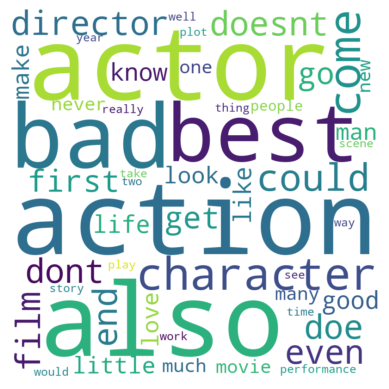

In [ ]:
tfidf_model = TfidfVectorizer(max_features=50)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
bests= list(tfidf_df.columns)
print(bests)
wordcloud = WordCloud(width = 800, height = 800, 
    background_color ='white', 
    max_words=200,
    stopwords = [],
    min_font_size = 10).generate(' '.join(bests))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
list(bag_of_word_df.columns)

['character',
 'even',
 'film',
 'get',
 'like',
 'make',
 'movie',
 'one',
 'scene',
 'time']